In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (2).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/bench-press-machine.jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (4).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (53).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/download (3).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (52).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (13).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (39).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (9).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (22).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (5).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (2).png
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (19).jpg
/kaggle/

<a id="4"></a>
## Convolutional Neural Network 
* CNN is used for image classification, object detection 
* <a href="https://ibb.co/kV1j9p"><img src="https://preview.ibb.co/nRkBpp/gec2.jpg" alt="gec2" border="0"></a>
<a id="5"></a>
### What is Convolution Operation?
* We have some image and feature detector(3*3)
* Feature detector does not need to be 3 by 3 matrix. It can be 5 by 5 or 7 by 7.
* Feature detector = kernel = filter
* Feauture detector detects features like edges or convex shapes. Example, if out input is dog, feature detector can detect features like ear or tail of the dog.
* feature map = conv(input image, feature detector). Element wise multiplication of matrices.
* feature map = convolved feature
* Stride = navigating in input image.
* We reduce the size of image. This is important bc code runs faster. However, we lost information. 
* We create multiple feature maps bc we use multiple feature detectors(filters).
* Lets look at gimp. Edge detect: [0,10,0],[10,-4,10],[0,10,0]
* <a href="https://imgbb.com/"><img src="https://image.ibb.co/m4FQC9/gec.jpg" alt="gec" border="0"></a>
* After having convolution layer we use ReLU to break up linearity. Increase nonlinearity. Because images are non linear.
* <a href="https://ibb.co/mVZih9"><img src="https://preview.ibb.co/gbcQvU/RELU.jpg" alt="RELU" border="0"></a>
<a id="6"></a>


<a id="1"></a>
## Loading the Data Set
* In this part we load and split the data.

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path to your dataset directory
dataset_dir = '/kaggle/input/gym-equipment-image/Gym Equipment'

# The paths for the training and validation directories
train_dir = '/kaggle/working/training'
val_dir = '/kaggle/working/validation'

# The categories of your gym equipment
categories = ['Bench Press','Dumbells', 'Elliptical Machine', 'Recumbent Bike', 'Smith Machine']

# Split ratio for validation
val_split_ratio = 0.2

# Create the training and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for category in categories:
    # Create category-specific subdirectories in both the training and validation directories
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    
    # Get the full path for the current category
    category_path = os.path.join(dataset_dir, category)
    
    # Check if the category path exists
    if not os.path.exists(category_path):
        print(f"Category path does not exist: {category_path}")
        continue
    
    # List all files in the category directory
    all_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
    
    # Split the files into training and validation sets
    train_files, val_files = train_test_split(all_files, test_size=val_split_ratio)
    
    # Copy the training files to the training directory
    for file_name in train_files:
        shutil.copy(os.path.join(category_path, file_name), os.path.join(train_dir, category, file_name))
        
    # Copy the validation files to the validation directory
    for file_name in val_files:
        shutil.copy(os.path.join(category_path, file_name), os.path.join(val_dir, category, file_name))


We import necessary modules and TensorFlow. TensorFlow is an open-source machine learning library. Keras, a part of TensorFlow, is used for building and training deep learning models.

In [3]:

import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Data Preparation
We define the base directory for our dataset and specify the subdirectories for training and validation sets.

In [4]:
# Define paths
base_dir = '/kaggle/working'
train_dir = os.path.join(base_dir, 'training')
val_dir = os.path.join(base_dir, 'validation')

We set the image dimensions and batch size for the model training.

In [5]:
# Define image dimensions
img_width, img_height = 150, 150
batch_size = 32

# Data Augmentation and Preprocessing
Data augmentation is used to increase the diversity of the training set by applying random transformations.


### Data Augmentation

Data augmentation refers to the process of generating new training samples from the existing ones by applying random transformations that yield believable-looking images. This is crucial for several reasons:

1. **Increasing Dataset Size**: In deep learning, having a larger dataset generally leads to better models. However, collecting and labeling new data can be time-consuming and expensive. Data augmentation provides a practical way of increasing the size of the training dataset.

2. **Reducing Overfitting**: Overfitting occurs when a model learns patterns specific to the training data, which don't generalize to new data. By introducing variety in the training data, augmentation helps the model generalize better.

3. **Real-world Variability**: It ensures that the model is exposed to the variety of ways an object can appear in real-world scenarios, such as different orientations, sizes, and lighting conditions.

The `ImageDataGenerator` class in Keras facilitates data augmentation with parameters like `rotation_range`, `width_shift_range`, `height_shift_range`, `shear_range`, `zoom_range`, and `horizontal_flip`. Each of these parameters randomly alters the images in a specified way, simulating different real-world conditions.

### Normalization

Normalization is a crucial preprocessing step in deep learning. It involves scaling input data to fall within a certain range, typically 0 to 1. This is achieved by dividing the pixel values by 255 (since RGB values range from 0 to 255). The reasons for normalization include:

1. **Speeding Up Training**: Normalized data helps in speeding up the convergence of the training process because it ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes optimization easier and faster.

2. **Reducing Internal Covariate Shift**: It helps in reducing internal covariate shift (the change in the distribution of network activations due to the change in network parameters during training), which again helps in faster convergence.

3. **Consistency with Pre-trained Models**: When using pre-trained models, it's important to preprocess your data in the same way the model was originally trained. Most pre-trained models expect input data to be normalized.

### Reshaping

Reshaping refers to resizing the input images to a fixed size, which is a requirement for most neural networks:

1. **Uniformity**: Neural networks expect input data to be of the same size. Since real-world datasets often contain images of varying dimensions, reshaping ensures uniformity in the input data.

2. **Model Architecture Requirements**: Some architectures, especially those using convolutional layers, are designed to work with specific input sizes.

3. **Computational Efficiency**: Resizing images to a smaller, uniform size can also help reduce the computational load, making the training process faster.

### Other Preprocessing Steps

Other common preprocessing steps might include:

- **Color Space Conversion**: Depending on the model and the task, sometimes images are converted from one color space to another (like RGB to grayscale).
- **Data Splitting**: Dividing the dataset into training, validation, and test sets to train the model, tune hyperparameters, and evaluate performance, respectively.
- **Class Encoding**: Encoding class labels in a format suitable for neural network training, like one-hot encoding for categorical targets.

In summary, each preprocessing step, including data augmentation, normalization, and reshaping, plays a vital role in preparing the data for efficient and effective training of deep learning models. These steps collectively help in improving the model's performance and its ability to generalize from the training data to real-world scenarios.

In [6]:
# Data augmentation configuration for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data augmentation for validation (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation data generator
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2137 images belonging to 5 classes.
Found 536 images belonging to 5 classes.


# Loading and Configuring the Base Model
1. MobileNetV2: We are using MobileNetV2 as our base model. MobileNetV2 is a popular, lightweight deep learning model for image classification, known for its efficiency on mobile devices. It is pre-trained on ImageNet, a large dataset with millions of images across thousands of categories.
2. Input Shape: input_shape=(img_width, img_height, 3) specifies the shape of the input images. In our case, it is 150x150 pixels with 3 color channels (RGB).
3. Include Top: include_top=False means we are not including the top (or the last) fully connected layer of the MobileNetV2 model. This is because we want to add our own dense layers for our specific classification task.
4. Weights: weights='imagenet' implies using weights from training on the ImageNet dataset, leveraging transfer learning.
5. Trainable: base_model.trainable = False freezes the layers of MobileNetV2, so their weights will not be updated during training. This is done to leverage the learned features without altering them.

In [7]:
# Load MobileNetV2 as base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_width, img_height, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model


2023-12-16 07:20:58.152489: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-16 07:20:58.152602: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-16 07:20:58.152712: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-16 07:20:58.152798: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-16 07:20:58.152875: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-16 07:20:58.153069: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-16 07:20:58.153168: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

9406464/9406464 [==============================] - 0s 0us/step


# Building the Custom Model
1. GlobalAveragePooling2D: This layer is used to reduce the spatial dimensions of the output from the MobileNetV2. It helps in reducing the number of parameters, which decreases the computational cost and complexity.

2. Dense Layers: These are fully connected layers. Dense(128, activation='relu') adds a hidden layer with 128 neurons and ReLU activation. This layer learns the higher-level features.

3. Dropout: Dropout(0.2) is a regularization technique where randomly selected neurons are ignored during training, reducing the risk of overfitting.
* <a href="https://ibb.co/jGcvVU"><img src="https://preview.ibb.co/e7yPPp/dropout.jpg" alt="dropout" border="0"></a>

4. Output Layer: The final layer, Dense(5, activation='softmax'), is the output layer with 5 neurons, each representing a class. The softmax activation function is used for multi-class classification, providing probabilities for each class.
<a id="9"></a>
### Full Connection
* Neurons in a fully connected layer have connections to all activations in the previous layer
* Artificial Neural Network
* <a href="https://ibb.co/hsS14p"><img src="https://preview.ibb.co/evzsAU/fullyc.jpg" alt="fullyc" border="0"></a>

In [8]:
# Define the model
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')  # Final output layer with 5 classes
])

# Model Compilation
1. Loss Function: categorical_crossentropy is used as the loss function, suitable for multi-class classification problems.That means that we have multi class.
* <a href="https://ibb.co/jm1bpp"><img src="https://preview.ibb.co/nN3ZaU/cce.jpg" alt="cce" border="0"></a>

2. Optimizer: Adam with a learning rate of 0.001 is used. Adam optimizer is efficient and requires less memory, and its adaptive learning rates help converge faster.

3. Metrics: We are using accuracy as the metric to evaluate the performance of the model.

In [9]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

# Custom Callback for Training Control
This custom callback function is designed to stop training once the model achieves an accuracy of 99% on both the training and validation datasets. This is to prevent overfitting and to save computational resources.

In [10]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.98):
            print('\nReached 98% accuracy for both training and validation. Stopping training.')
            self.model.stop_training = True
            
callback = AccuracyThresholdCallback()

# Training the Model
1. Model Fitting: The model is trained using the fit method with the training and validation data generators.
 
2. Steps per Epoch: steps_per_epoch determines how many batches of samples to use in one epoch. This is set to the total number of samples in the training set divided by the batch size.
 
3. Epochs: The model is set to train for a maximum of 1000 epochs, but it may stop earlier if the custom callback condition is met.
 
4. Validation Data: The model is also validated on a separate dataset to ensure that it generalizes well.
 
5. Callbacks: The custom accuracy threshold callback is used

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=1000,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callback]
)


Epoch 1/1000
30/66 [============>.................] - ETA: 9s - loss: 0.5469 - accuracy: 0.8479

/usr/local/lib/python3.10/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


66/66 [==============================] - 23s 313ms/step - loss: 0.3401 - accuracy: 0.8993 - val_loss: 0.1047 - val_accuracy: 0.9688
Epoch 2/1000
66/66 [==============================] - 19s 292ms/step - loss: 0.1296 - accuracy: 0.9539 - val_loss: 0.0987 - val_accuracy: 0.9727
Epoch 3/1000
66/66 [==============================] - 19s 288ms/step - loss: 0.1069 - accuracy: 0.9653 - val_loss: 0.0796 - val_accuracy: 0.9727
Epoch 4/1000
66/66 [==============================] - 19s 290ms/step - loss: 0.0996 - accuracy: 0.9672 - val_loss: 0.0821 - val_accuracy: 0.9648
Epoch 5/1000
66/66 [==============================] - 19s 291ms/step - loss: 0.1054 - accuracy: 0.9648 - val_loss: 0.0777 - val_accuracy: 0.9824
Epoch 6/1000
66/66 [==============================] - 19s 288ms/step - loss: 0.0938 - accuracy: 0.9701 - val_loss: 0.0657 - val_accuracy: 0.9824
Epoch 7/1000
66/66 [==============================] - 19s 289ms/step - loss: 0.0673 - accuracy: 0.9762 - val_loss: 0.0663 - val_accuracy: 0.980

In [12]:
# Save the model
model.save('model.h5')

/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# The Confusion Matrix
A confusion matrix is crucial for understanding not just the overall accuracy of the model, but also the specific types of errors it is making. For instance, it can reveal if the model is frequently confusing two particular classes, which can be critical for further model tuning and improvement.

17/17 [==============================] - 3s 128ms/step


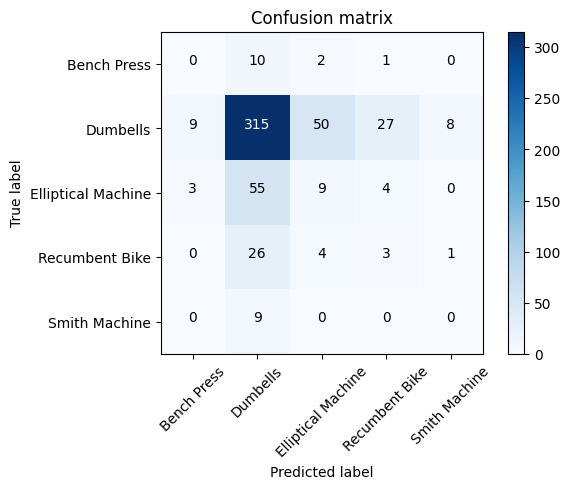

In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Predict the values from the validation dataset
Y_pred = model.predict(validation_generator, validation_generator.samples // batch_size+1)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert validation observations to one hot vectors
Y_true = validation_generator.classes

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Class names
class_names = ['Bench Press', 'Dumbells', 'Elliptical Machine', 'Recumbent Bike', 'Smith Machine']

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix with class names
plot_confusion_matrix(confusion_mtx, classes=class_names)


The model.summary() function in Keras is used to print a summary representation of the neural network.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2422597 (9.24 MB)
Trainable params: 164613

In [15]:
class_indices = train_generator.class_indices
print(class_indices)  

{'Bench Press': 0, 'Dumbells': 1, 'Elliptical Machine': 2, 'Recumbent Bike': 3, 'Smith Machine': 4}


visualize the training and validation accuracy of a neural network over the course of its training
By plotting both training and validation accuracy on the same graph, you can easily compare them:

1. Training Accuracy (Train acc): This line represents the model's accuracy on the training dataset. It shows how well the model is learning and fitting the training data over each epoch. An upward trend in this line indicates that the model is effectively learning from the training data.

2. Validation Accuracy (Validation acc): This line represents the model's accuracy on a validation dataset that is not used in training, providing an indication of how well the model generalizes to new, unseen data.

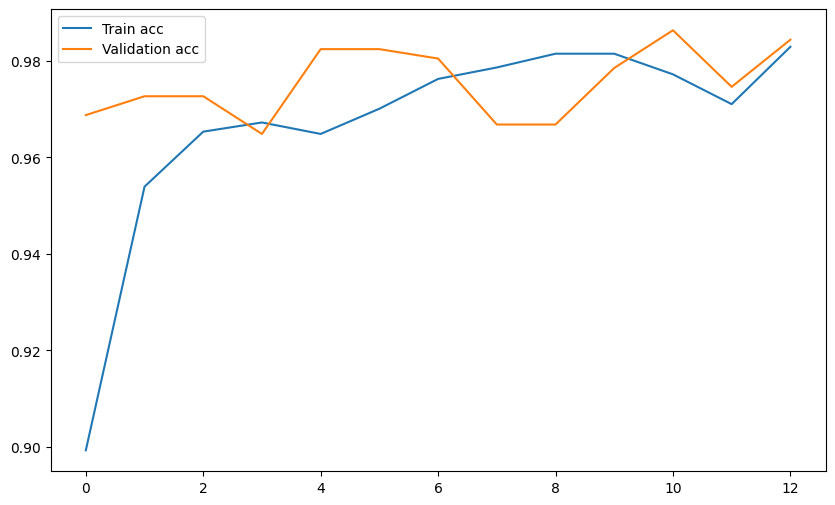

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

Visualize the training and validation loss of a neural network over its training epochs,

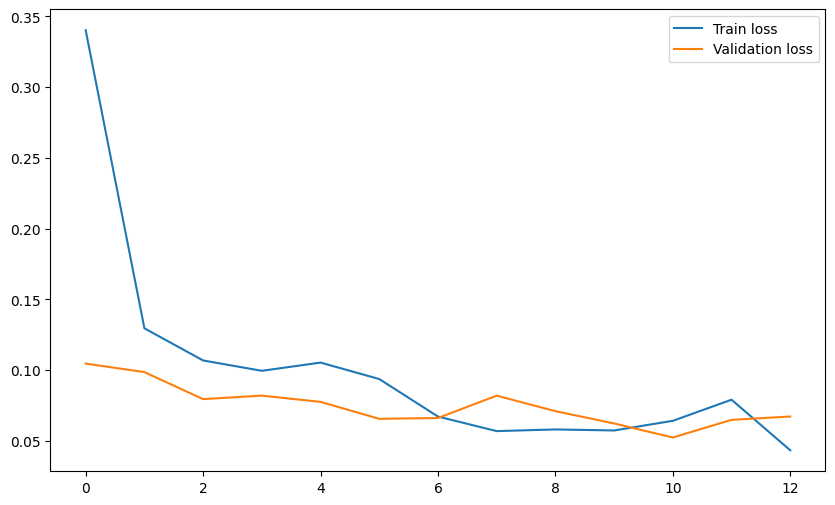

In [17]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

# Testing

1/1 [==============================] - 1s 1s/step


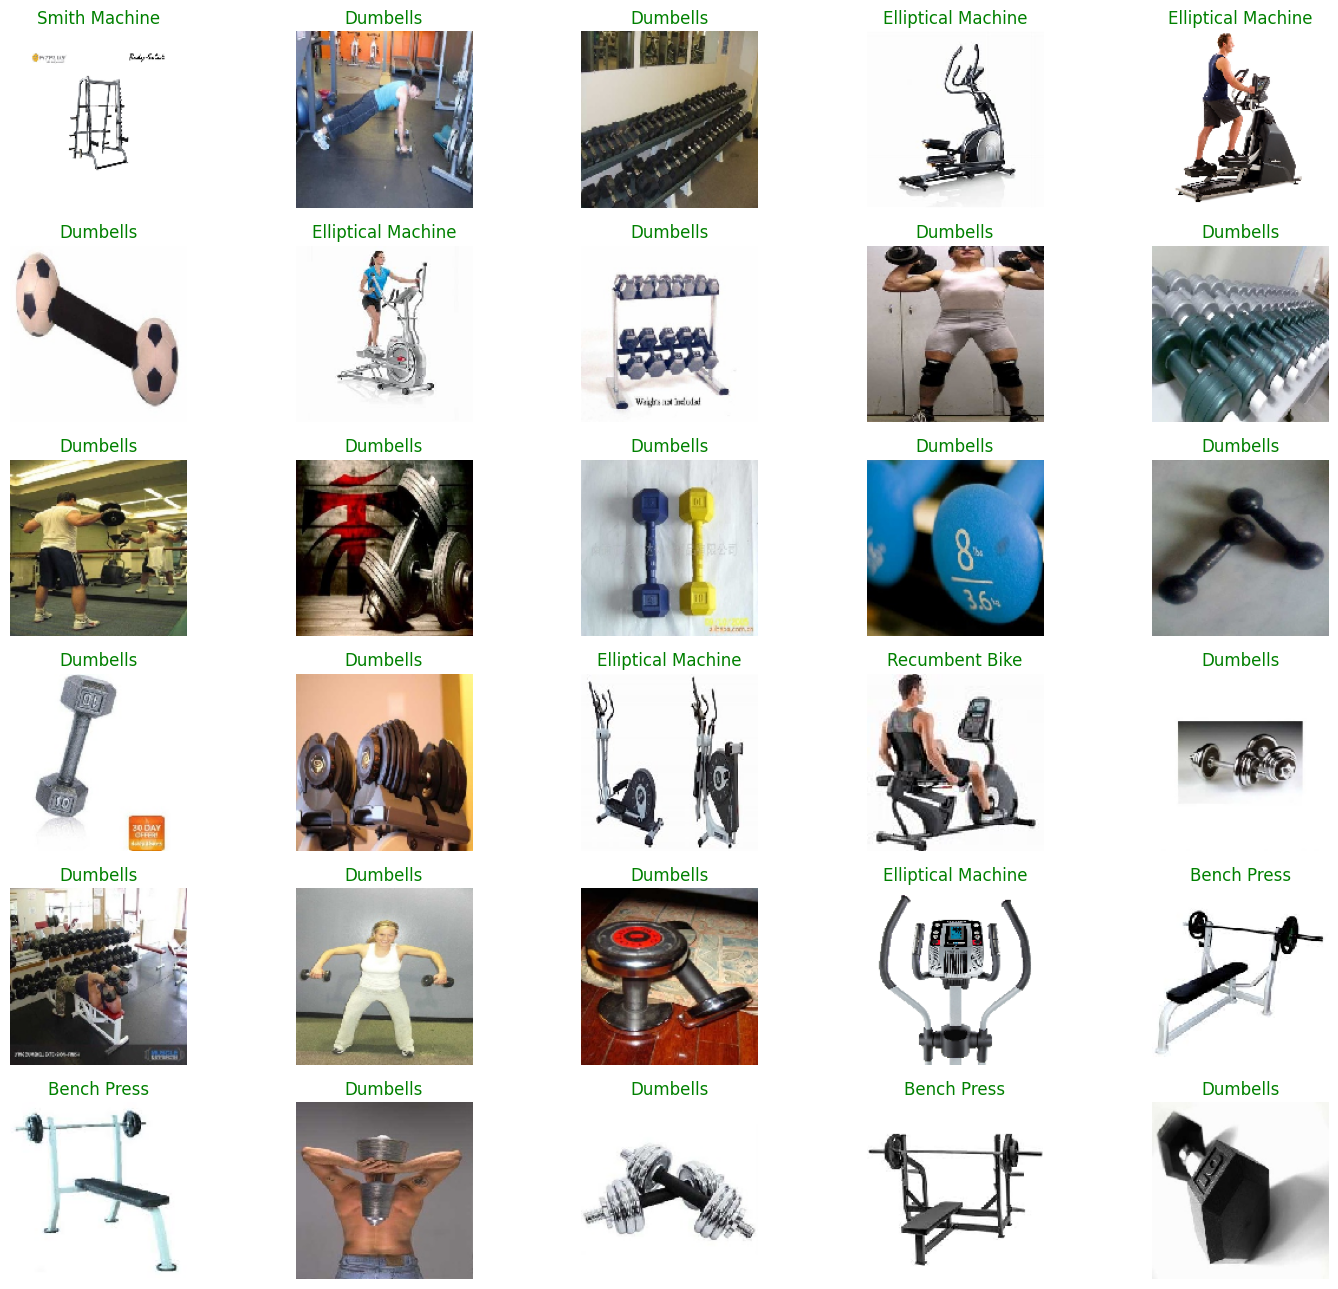

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('/kaggle/working/model.h5')

# Assuming validation_generator is already set up and is part of the code that was provided
# Make sure to use the correct directory for the validation data
# validation_generator = ...

# Get a batch of images from the validation generator
img, labels = next(validation_generator)

# Define the class indices (mapping) as obtained previously
class_indices = {'Bench Press': 0, 'Dumbells': 1, 'Elliptical Machine': 2, 'Recumbent Bike': 3, 'Smith Machine': 4}

# Reverse the class indices dictionary to map indices to class names for display
indices_class = {v: k for k, v in class_indices.items()}

# Predict the class of each image in the batch
predictions = model.predict(img)

# Set up the figure for plotting images
plt.figure(figsize=(15, 13))

# Plot each image in the batch
for i in range(30):  # Assuming you want to plot 30 images
    ax = plt.subplot(6, 5, i + 1)  # Adjust the number of rows and cols accordingly
    plt.imshow(img[i])

    # Get the predicted and true labels
    predicted_label = indices_class[np.argmax(predictions[i])]
    true_label = indices_class[np.argmax(labels[i])]

    # Set the title of each plot to the predicted label
    # If the prediction is correct, the title is set in green; otherwise, it's set in red
    title_color = 'green' if predicted_label == true_label else 'red'
    plt.title(predicted_label, color=title_color)
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
